In [1]:
import os
from os.path import dirname

root_dir = dirname(os.getcwd())
os.chdir(root_dir)

In [2]:
import random
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.nn.ode import get_solution
from src.utils.data import extract_params, extract_cumulative_cases, extract_temperature_rainfall

In [3]:
with open('data/configs/weather_data_params.yaml', 'r') as file:
    location_params = yaml.safe_load(file)

location_list = list(location_params['location'].keys())

In [4]:
state_order = [
    'E_0', 'L_0', 'P_0', 'M_s_0', 'M_e_0', 'M_i_0',
    'H_s_0', 'H_e_0', 'H_i_0', 'H_r_0'
]
criterion = torch.nn.MSELoss()

--------------------------------------------------------------------------------
Processing location: bello


/tmp/ipykernel_781/2701495263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_dict[k] = torch.tensor(v, dtype=torch.float32)


--------------------------------------------------------------------------------
Processing location: iquitos


/tmp/ipykernel_781/2701495263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_dict[k] = torch.tensor(v, dtype=torch.float32)


--------------------------------------------------------------------------------
Processing location: sanjuan


/tmp/ipykernel_781/2701495263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_dict[k] = torch.tensor(v, dtype=torch.float32)


--------------------------------------------------------------------------------
Processing location: vietnam


/tmp/ipykernel_781/2701495263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_dict[k] = torch.tensor(v, dtype=torch.float32)


--------------------------------------------------------------------------------
Processing location: philippines


/tmp/ipykernel_781/2701495263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_dict[k] = torch.tensor(v, dtype=torch.float32)


--------------------------------------------------------------------------------
Processing location: cambodia


/tmp/ipykernel_781/2701495263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_dict[k] = torch.tensor(v, dtype=torch.float32)


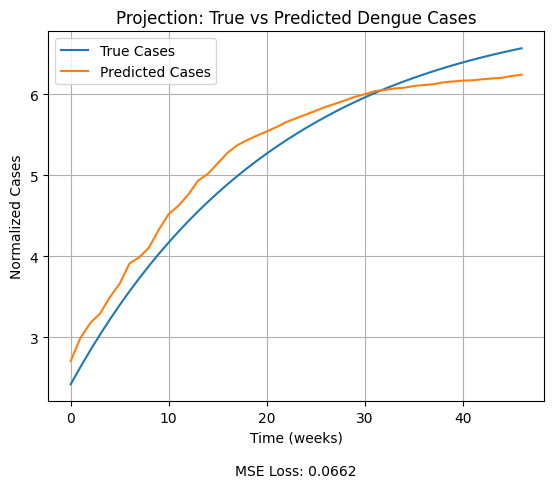

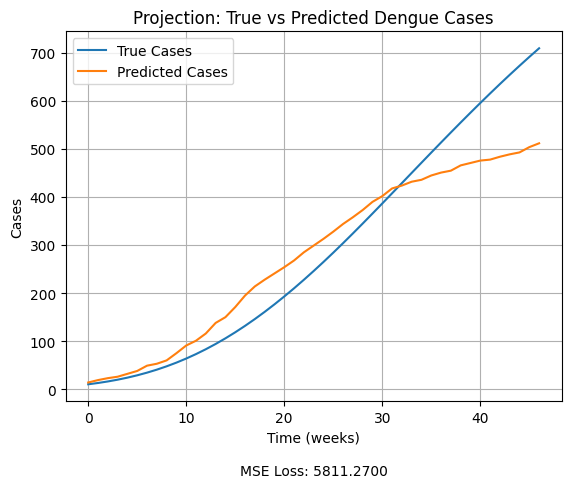

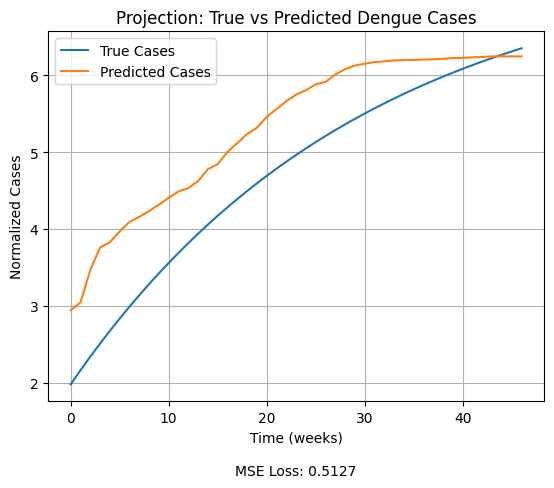

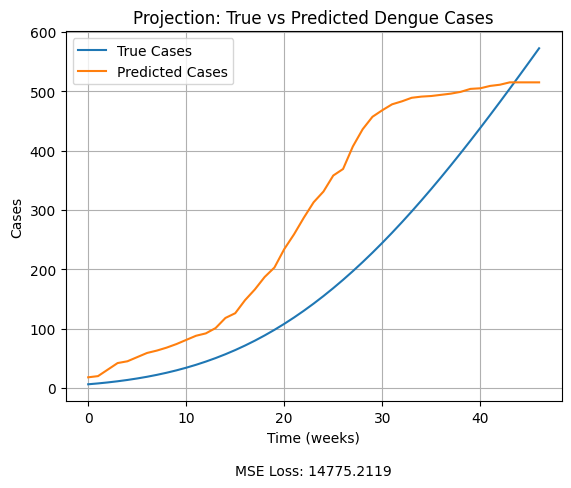

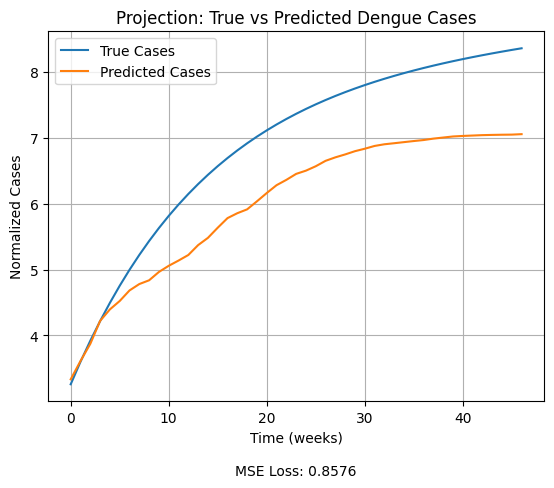

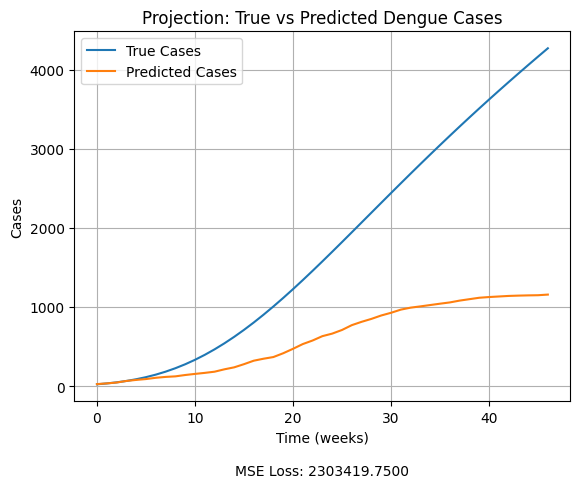

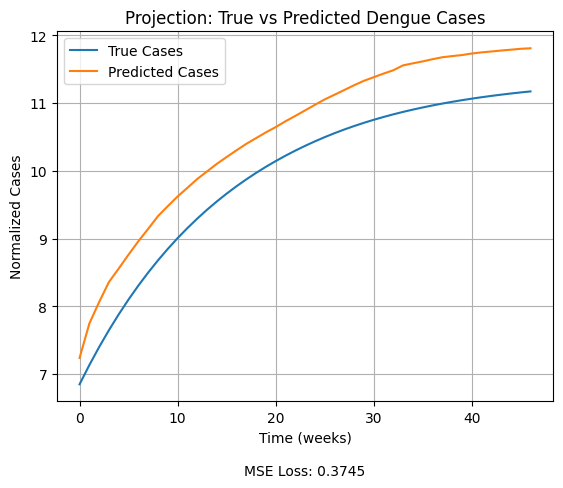

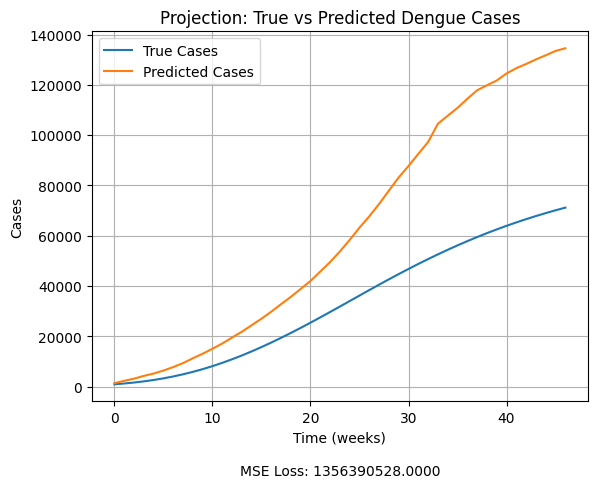

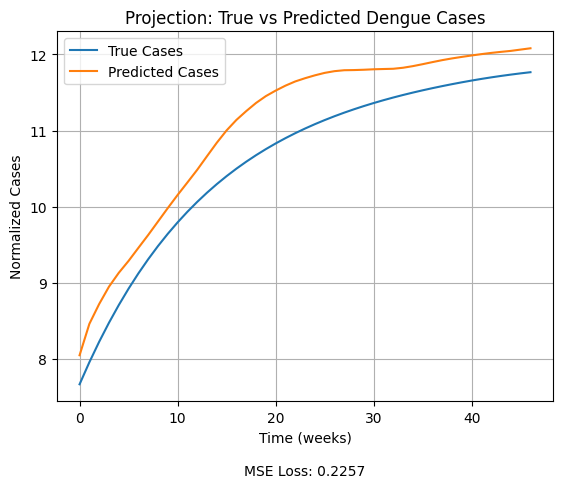

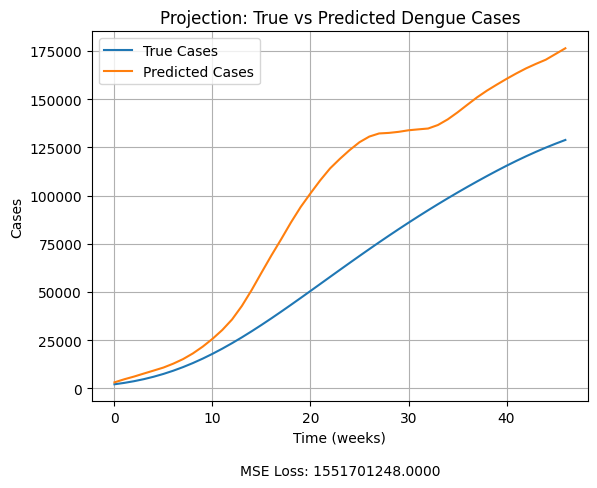

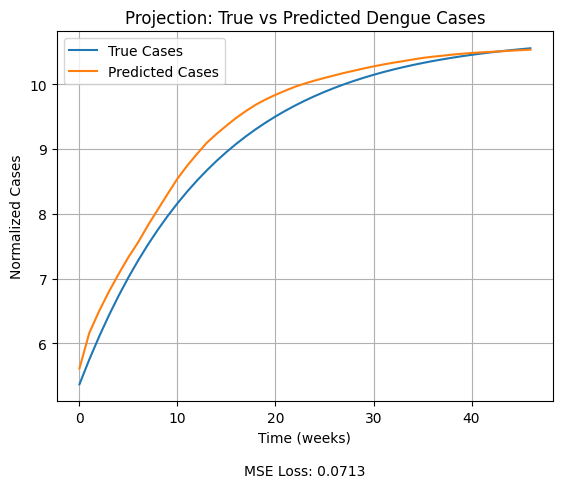

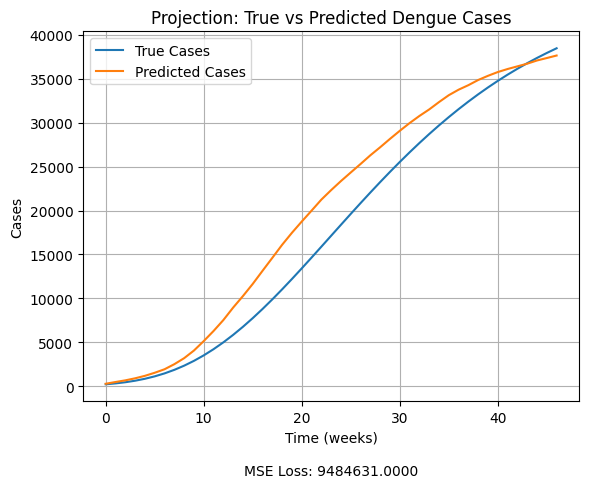

In [5]:
for location in location_list:
    print('-' * 80)
    print(f'Processing location: {location}')

    data_csv_path = f'data/projection/{location}/data.csv'
    predicted_params_path = f'results/{location}/best_params.yaml'

    param_dict = extract_params(predicted_params_path)
    cumulative_cases = extract_cumulative_cases(data_csv_path).log1p()
    temperature_data, rainfall_data = extract_temperature_rainfall(
        data_csv_path)

    for k, v in param_dict.items():
        param_dict[k] = torch.tensor(v, dtype=torch.float32)

    t_original = torch.linspace(
        0,
        1,
        steps=len(cumulative_cases),
        dtype=torch.float32,
    )
    t_eval = torch.linspace(
        0,
        1,
        steps=len(cumulative_cases),
        dtype=torch.float32,
    )

    y0_list = [cumulative_cases[0]]
    for state_name in state_order:
        state_val = param_dict[state_name]
        y0_list.append(torch.atleast_1d(state_val))
    y0 = torch.stack(y0_list).squeeze(-1)

    solution = get_solution(
        t_eval=t_eval,
        t_original=t_original,
        y0=y0,
        temperature_arr=temperature_data,
        rainfall_arr=rainfall_data,
        param_dict=param_dict,
    )

    pred_data_normalized = solution.t()[0][1:]
    true_data_normalized = cumulative_cases[1:].squeeze()

    pred_data = pred_data_normalized.expm1()
    true_data = true_data_normalized.expm1()

    loss_normalized = criterion(pred_data_normalized, true_data_normalized)
    loss = criterion(pred_data, true_data)

    fig1, ax1_fig1 = plt.subplots()
    ax1_fig1.plot(pred_data_normalized, label='True Cases')
    ax1_fig1.plot(true_data_normalized, label='Predicted Cases')
    ax1_fig1.set_xlabel('Time (weeks)')
    ax1_fig1.set_ylabel('Normalized Cases')
    ax1_fig1.set_title('Projection: True vs Predicted Dengue Cases')
    ax1_fig1.text(0.5, -0.2, f'MSE Loss: {loss_normalized:.4f}',
                  transform=ax1_fig1.transAxes, ha='center')
    ax1_fig1.legend()
    ax1_fig1.grid(True)

    fig2, ax1_fig2 = plt.subplots()
    ax1_fig2.plot(pred_data, label='True Cases')
    ax1_fig2.plot(true_data, label='Predicted Cases')
    ax1_fig2.set_xlabel('Time (weeks)')
    ax1_fig2.set_ylabel('Cases')
    ax1_fig2.set_title('Projection: True vs Predicted Dengue Cases')
    ax1_fig2.text(
        0.5, -0.2, f'MSE Loss: {loss:.4f}', transform=ax1_fig2.transAxes, ha='center')
    ax1_fig2.legend()
    ax1_fig2.grid(True)

    fig1.savefig(
        f'results/{location}/normalized_projection.png', bbox_inches='tight')
    fig2.savefig(
        f'results/{location}/cumulative_projection.png', bbox_inches='tight')

In [6]:
# location = 'philippines'
# data_csv_path = f'data/projection/{location}/data.csv'
# predicted_params_path = f'results/{location}/best_params.yaml'

In [7]:
# param_dict = extract_params(predicted_params_path)
# cumulative_cases = extract_cumulative_cases(data_csv_path).log1p()
# temperature_data, rainfall_data = extract_temperature_rainfall(data_csv_path)

In [8]:
# for k, v in param_dict.items():
#     param_dict[k] = torch.tensor(v, dtype=torch.float32)

In [9]:
# t_original = torch.linspace(
#     0,
#     1,
#     steps=len(cumulative_cases),
#     dtype=torch.float32,
# )
# t_eval = torch.linspace(
#     0,
#     1,
#     steps=len(cumulative_cases),
#     dtype=torch.float32,
# )

In [10]:
# state_order = [
#     'E_0', 'L_0', 'P_0', 'M_s_0', 'M_e_0', 'M_i_0',
#     'H_s_0', 'H_e_0', 'H_i_0', 'H_r_0'
# ]
# y0_list = [cumulative_cases[0]]
# for state_name in state_order:
#     state_val = param_dict[state_name]
#     y0_list.append(torch.atleast_1d(state_val))
# y0 = torch.stack(y0_list).squeeze(-1)

In [11]:
# solution = get_solution(
#     t_eval=t_eval,
#     t_original=t_original,
#     y0=y0,
#     temperature_arr=temperature_data,
#     rainfall_arr=rainfall_data,
#     param_dict=param_dict,
# )

In [12]:
# pred_data_normalized = solution.t()[0][1:]
# true_data_normalized = cumulative_cases[1:].squeeze()

# pred_data = pred_data_normalized.expm1()
# true_data = true_data_normalized.expm1()

In [13]:
# criterion = torch.nn.MSELoss()
# loss_normalized = criterion(pred_data_normalized, true_data_normalized)
# loss = criterion(pred_data, true_data)

In [14]:
# fig1, ax1_fig1 = plt.subplots()
# ax1_fig1.plot(pred_data_normalized, label='True Cases')
# ax1_fig1.plot(true_data_normalized, label='Predicted Cases')
# ax1_fig1.set_xlabel('Time (weeks)')
# ax1_fig1.set_ylabel('Normalized Cases')
# ax1_fig1.set_title('Projection: True vs Predicted Dengue Cases')
# ax1_fig1.text(0.5, -0.2, f'MSE Loss: {loss_normalized:.4f}', transform=ax1_fig1.transAxes, ha='center')
# ax1_fig1.legend()
# ax1_fig1.grid(True)
# plt.show()

In [15]:
# fig2, ax1_fig2 = plt.subplots()
# ax1_fig2.plot(pred_data, label='True Cases')
# ax1_fig2.plot(true_data, label='Predicted Cases')
# ax1_fig2.set_xlabel('Time (weeks)')
# ax1_fig2.set_ylabel('Cases')
# ax1_fig2.set_title('Projection: True vs Predicted Dengue Cases')
# ax1_fig2.text(0.5, -0.2, f'MSE Loss: {loss:.4f}', transform=ax1_fig2.transAxes, ha='center')
# ax1_fig2.legend()
# ax1_fig2.grid(True)
# plt.show()

In [16]:
# fig1.savefig(f'results/{location}/normalized_projection.png', bbox_inches='tight')
# fig2.savefig(f'results/{location}/cumulative_projection.png', bbox_inches='tight')